In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
import itertools
import pingouin as pg
import seaborn as sns
import nibabel as nib


from scipy.cluster.hierarchy import ClusterWarning
from warnings import simplefilter
from scipy.cluster.hierarchy import (linkage, optimal_leaf_ordering, leaves_list, dendrogram)
simplefilter("ignore", ClusterWarning)
simplefilter(action='ignore', category=FutureWarning)

/volatile/miniconda3/envs/networks/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
relabeled_encoding=pd.read_csv('../../DerivedData/lookup_parcellation_labels.csv')
ages = pd.read_csv('../../DerivedData/all3groups_with_ages.csv', index_col=0)
ages.rename(columns={'subject': 'subject_id' ,
                     'session' : 'session_id'}, inplace=True)
rois = relabeled_encoding['new_label'].values
groups = pd.read_csv('../../DerivedData/matched_subjects_after_cleaning_incomplete.csv', index_col=0)
df = pd.read_csv('../../Results/extracted_metrics/ROIs_median_diffusion.csv')
metrics=['FA', 'L1', 'RD', 'MD', 'OD', 'NDI']
df = pd.merge(df, ages, on=['session_id', 'subject_id'])

### Subject-wise relationship with PMA at scan

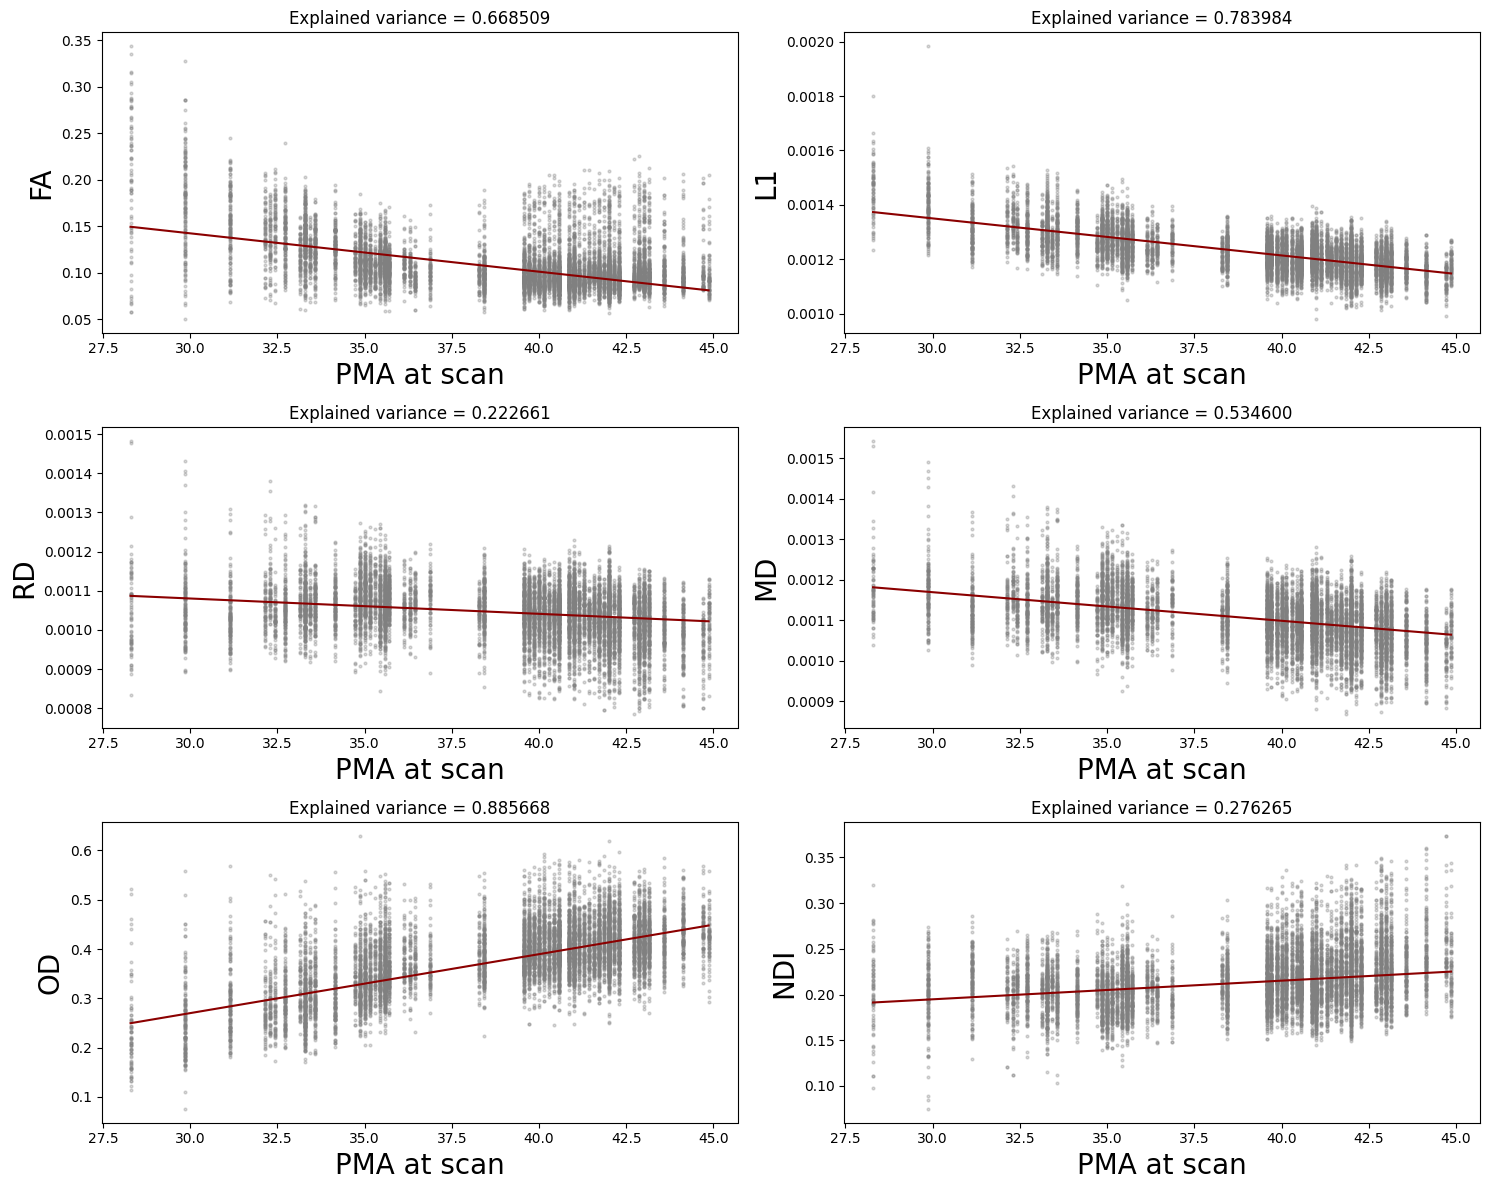

In [3]:
fig, axs = plt.subplots(3, 2, figsize=(15, 12))
axs=axs.ravel()
for r, metric in enumerate(metrics): 
    
    all_regions = ['{}_{}'.format(roi,metric) for roi in rois ]
    mean = np.median(df[all_regions].values ,axis=1)
    ages = df['scan_age '].values
    ind = np.argsort(ages)
    m, b = np.polyfit(np.float32(ages[ind]), np.float32(mean[ind]), 1)
    axs[r].plot(ages[ind], m* ages[ind] + b, c = 'darkred')
    mae = explained_variance_score(mean[ind],  m*ages[ind] + b)
    #mae = r2_score(mean[ind],  m*ages[ind] + b)
    axs[r].set_title('Explained variance = {:.6f}'.format(mae))
    #axs[r].plot(ages[ind], mean[ind],  c='darkred', alpha = 0.6)
    
    for i, roi in enumerate(rois):
        axs[r].scatter(df['scan_age '].values, df['{}_{}'.format(roi,metric)].values, s=4, c='gray', alpha = 0.3)
           
    axs[r].set_ylabel(metric, fontsize=20)
    axs[r].set_xlabel('PMA at scan', fontsize=20)
plt.tight_layout()
#plt.savefig('../../Results/figures/GM_correlome/regional_subjects_with_PMAscan.jpg', dpi=200)
plt.show()
    #for r, metric in enumerate(metrics):

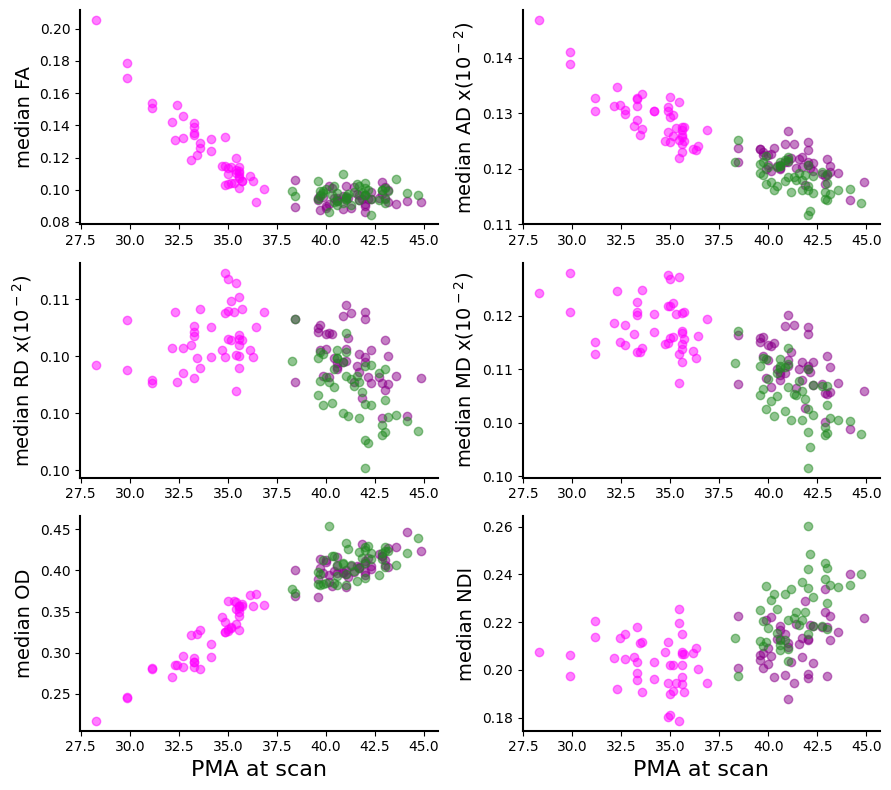

In [17]:
from matplotlib.ticker import FormatStrFormatter

global_GM = {}
for metric in metrics:
    cols = ['{}_{}'.format(roi,metric) for roi in rois]
    global_GM[metric] = np.median( df[cols].values, axis=1)
    
fig, axs = plt.subplots(3, 2, figsize=(9, 8)) #, sharey='row', sharex='col')
axs = axs.ravel()                      
for r, metric in enumerate(metrics):
    
    if metric in ['FA', 'NDI', 'OD']:
        multiplier = 1
    else: 
         multiplier = 100
    
    for group, color in zip(['PT_session2_id', 'PT_session1_id', 'FT_session_id'],['darkmagenta', 'magenta', 'forestgreen']):
        idx = df[df.session_id.isin(groups[group].values)].index
        
        #axs[r].scatter( df.loc[idx]['birth_age '], global_GM[metric][idx],c = color, alpha=0.5)
        axs[r].scatter( df.loc[idx]['scan_age '], global_GM[metric][idx] * multiplier,c = color, alpha=0.5)
        
    #axs[r,0].scatter( df['birth_age '], global_GM[metric],c = 'gray', alpha=0.5)
    #axs[r,1].scatter( df['scan_age '], global_GM[metric],c = 'gray', alpha=0.5)
    
    if metric not in ['FA', 'NDI', 'OD']:
        if metric == 'L1':
            name  = 'AD x(10$^-$$^2$)'
        else:
            name = '{} x(10$^-$$^2$)'.format(metric)
    else: 
        name = metric
    axs[r].set_ylabel('median {}'.format(name), fontsize=14)
    axs[r].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
 
axs[r-1].set_xlabel('PMA at scan', fontsize=16)
axs[r].set_xlabel('PMA at scan', fontsize=16)

# Make prettier
for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(1.5)
    #ax.tick_params(axis='y', labelsize=14) 
    #ax.tick_params(axis='x', labelsize=14)

plt.tight_layout()
plt.savefig('../../Results/GC_FC_paper/figures/004_median_global_GM_withPMA.jpg', dpi=200)
plt.show()

### Difference between groups of median global diffusion metric 


In [35]:
idx_Ses2 =groups['PT_session2_id'].values
idx_Ses1 = groups['PT_session1_id'].values
idx_FT = groups['FT_session_id'].values
for metric in metrics:
    df['global_{}'.format(metric)] =  global_GM[metric]
    
for group, label, cat in zip(['PT_session2_id', 'PT_session1_id', 'FT_session_id'], ['PT: Ses2', 'PT: Ses1', 'FT' ], 
                            [0,1,2]):
    df.loc[df.session_id.isin(groups[group].values), 'group'] = label
    df.loc[df.session_id.isin(groups[group].values), 'group_label'] = cat

In [67]:
comp_df = pd.DataFrame()
i=0
for comparison, names in zip([[idx_Ses1, idx_Ses2], [idx_Ses1, idx_FT], [idx_Ses2, idx_FT]],
                            ['PT: Ses 1 vs PT: Ses2','PT: Ses 1 vs FT','PT: Ses 2 vs FT']):
    comp_df.loc[i, 'comparison'] = names
    print(names)
    for metric in metrics: 
        group1 = df[df.session_id.isin(comparison[0])]['global_{}'.format(metric)].values
        group2 = df[df.session_id.isin(comparison[1])]['global_{}'.format(metric)].values
        comp = pg.ttest(group1, group2, paired=True)
        T, p = comp['T'].values[0],comp['p-val'].values[0] 
        
        comp_df.loc[i, 'T_{}'.format(metric)] = np.round(T,2)
        comp_df.loc[i, 'p_{}'.format(metric)] = p
        print('{}: T={:.4f}, p={:.4f}'.format(metric,T, p))
    i=i+1
_, p_cor = pg.multicomp(comp_df[['p_{}'.format(metric) for metric in metrics]].values, method='fdr_bh')
comp_df[['p_{}'.format(metric) for metric in metrics]] = np.round(p_cor.reshape(3,len(metrics)),5)

PT: Ses 1 vs PT: Ses2
FA: T=9.1601, p=0.0000
L1: T=11.6824, p=0.0000
RD: T=4.2283, p=0.0001
MD: T=10.2504, p=0.0000
OD: T=-17.1748, p=0.0000
NDI: T=-5.0631, p=0.0000
PT: Ses 1 vs FT
FA: T=7.4261, p=0.0000
L1: T=13.3401, p=0.0000
RD: T=7.3774, p=0.0000
MD: T=11.9621, p=0.0000
OD: T=-13.0293, p=0.0000
NDI: T=-8.8220, p=0.0000
PT: Ses 2 vs FT
FA: T=-2.2052, p=0.0327
L1: T=5.9608, p=0.0000
RD: T=5.4934, p=0.0000
MD: T=5.5506, p=0.0000
OD: T=-0.9646, p=0.3400
NDI: T=-5.6738, p=0.0000


In [68]:
comp_df

,comparison,T_FA,p_FA,T_L1,p_L1,T_RD,p_RD,T_MD,p_MD,T_OD,p_OD,T_NDI,p_NDI
0,PT: Ses 1 vs PT: Ses2,9.16,0.00000,11.68,0.0,4.23,0.00013,10.25,0.0,-17.17,0.00000,-5.06,0.00001
1,PT: Ses 1 vs FT,7.43,0.00000,13.34,0.0,7.38,0.00000,11.96,0.0,-13.03,0.00000,-8.82,0.00000
2,PT: Ses 2 vs FT,-2.21,0.03463,5.96,0.0,5.49,0.00000,5.55,0.0,-0.96,0.34003,-5.67,0.00000
